In [1]:
import os
import random
import warnings

import pandas as pd
import numpy as np
from typing import Union, List
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# np.random.seed(seed=1)
# L.seed_everything(seed=1, workers=True)

In [83]:
!export CUDA_VISIBLE_DEVICES=0,1

In [86]:
# Specify the GPU ID you want to use
gpu_id = [0]  # Change this to the ID of the GPU you want to use
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, gpu_id))

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Step 1: Load and Preprocess the Data

In [4]:
folder: str = "/data/experience/CSV"

sub_folders: list = [
    '/1.Deauth',
    '/2.Disas',
    '/3.(Re)Assoc',
    '/4.Rogue_AP',
    '/5.Krack',
    '/6.Kr00k',
    '/7.SSH',
    '/8.Botnet',
    '/9.Malware',
    '/10.SQL_Injection',
    '/11.SSDP',
    '/12.Evil_Twin',
    '/13.Website_spoofing'
]

In [5]:
# Load dataset
def load_fusion_dataset(idx: Union[int, List[int]], all: bool = False) -> pd.DataFrame:
    res = []
    
    for sub_folder in sub_folders:
        path: str = folder + sub_folder
        files: list = os.listdir(path)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=pd.errors.DtypeWarning)
        
            if all: df = pd.concat([pd.read_csv(path + '/' + file) for file in files])
            elif type(idx) == list: df = pd.concat([pd.read_csv(path + '/' + files[i % len(files)]) for i in idx])
            else: df = pd.read_csv(path + '/' + files[idx % len(files)])
        
        res.append(df)
    
    return pd.concat(res, axis=0)
        

def load_dataset(num: int = 1, all: bool = False) -> pd.DataFrame:
    if num < 1 or num > 13: return None
    
    path: str = folder + sub_folders[num-1]
    files: list = os.listdir(path)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=pd.errors.DtypeWarning)
        df = pd.concat([pd.read_csv(path + '/' + file) for file in files], ignore_index=True) if all else pd.read_csv(path + '/' + files[0])
    
    return df

In [6]:
# Preprocessing
def wireless_preprocessing(df_copy: pd.DataFrame) -> pd.DataFrame:
    # Filter protocols related with wireless attacks
    df_copy = df_copy[[col for col in df_copy.columns if col.startswith(('frame', 'radiotap', 'wlan', 'eapol', 'Label'))]]

    df_copy = df_copy.dropna(subset=['Label'])

    # fill NaN data
    for col in ['frame.encap_type', 'frame.len', 'frame.number', 'frame.time_delta', 'frame.time_epoch',
                'radiotap.channel.freq', 'radiotap.length', 'radiotap.timestamp.ts', 'wlan.fc.frag',
                'wlan.fc.order', 'wlan.fc.moredata', 'wlan.fc.protected', 'wlan.fc.pwrmgt',
                'wlan.fc.type', 'wlan.fc.retry', 'wlan.fc.subtype', 'wlan_radio.duration',
                'wlan_radio.channel', 'wlan_radio.data_rate', 'wlan_radio.frequency',
                'wlan_radio.signal_dbm', 'radiotap.datarate', 'radiotap.mactime', 'eapol.type']:
        df_copy[col] = df_copy[col].fillna(-10000.0)
    
    df_copy['eapol.type'] = df_copy['eapol.type'].fillna(-1.0)
    df_copy['eapol.len'] = df_copy['eapol.len'].fillna(0.0)
    df_copy['eapol.keydes.replay_counter'] = df_copy['eapol.keydes.replay_counter'].fillna(-1.0)
    df_copy['eapol.keydes.key_len'] = df_copy['eapol.keydes.key_len'].fillna(0.0)
    df_copy['wlan.duration'] = df_copy['wlan.duration'].fillna(0.0) 
    df_copy['wlan_radio.timestamp'] = df_copy['wlan_radio.timestamp'].fillna(0.0) 
    df_copy['radiotap.dbm_antsignal'] = df_copy['radiotap.dbm_antsignal'].fillna(-1000)
    df_copy['radiotap.rxflags'] = df_copy['radiotap.rxflags'].fillna('0xffffffff')
    df_copy['wlan.fc.ds'] = df_copy['wlan.fc.ds'].fillna('0xffffffff')
    df_copy['wlan_radio.phy'] = df_copy['wlan_radio.phy'].fillna(-1000.0)
    
    df_copy.loc[df_copy['wlan.country_info.fnm'] == 1.0, 'wlan.country_info.fnm'] = '1.0'
    df_copy.loc[df_copy['wlan_radio.phy'] == 'Normal', 'wlan_radio.phy'] = -1000.0

    # Change type of several flags columns
    df_copy.loc[:, 'radiotap.rxflags'] = df_copy['radiotap.rxflags'].apply(lambda x: int(x, 16) if type(x)==str else x)
    df_copy.loc[:, 'wlan_radio.phy'] = df_copy['wlan_radio.phy'].apply(lambda x: float(x) if type(x)==str else x)
    df_copy.loc[:, 'Label'] = df_copy['Label'].apply(lambda x: x != 'Normal')
    df_copy.loc[:, 'radiotap.present.tsft'] = df_copy['radiotap.present.tsft'].apply(lambda x: x == '1-0-0')
    df_copy.loc[:, 'radiotap.dbm_antsignal'] = df_copy['radiotap.dbm_antsignal'].apply(lambda x: int(x) if isinstance(x, (int, float)) else -int(x.split('-')[1]))
    df_copy.loc[:, 'wlan.fc.ds'] = df_copy['wlan.fc.ds'].apply(lambda x: int(x, 16))
    df_copy.loc[:, 'wlan.analysis.has_key'] = df_copy['wlan.analysis.kck'].isna()
    df_copy.loc[:, 'wlan.fixed.used'] = df_copy['wlan.fixed.timestamp'].notna()
    df_copy.loc[:, 'wlan.rsn.used'] = df_copy['wlan.rsn.ie.gtk.key'].notna()
    df_copy.loc[:, 'eapol.used'] = df_copy['eapol.type'].notna()
    
    df_copy = df_copy.astype({
        'radiotap.channel.flags.cck': 'bool', 
        'radiotap.channel.flags.ofdm': 'bool', 
        'Label': 'bool',
        'radiotap.present.tsft': 'bool',
        'radiotap.dbm_antsignal': 'int64',
        'radiotap.rxflags': 'int64',
        'wlan.fc.ds': 'int64'
    })

    # delete unnecessary columns
    drop_columns = [
        'frame.time', 'frame.time_delta_displayed', 'frame.time_relative',
        'wlan.analysis.kck', 'wlan.analysis.kek', 'wlan_radio.end_tsf', 'wlan_radio.start_tsf'
    ]
    df_copy = df_copy.drop(columns=drop_columns, axis=1)
    df_copy = df_copy[[col for col in df_copy.columns if not col.startswith(('wlan.fixed', 'wlan.rsn', 'wlan_rsn'))]]

    # Fill category data
    df_copy['wlan.bssid'] = df_copy['wlan.bssid'].fillna('-')
    df_copy['wlan.country_info.fnm'] = df_copy['wlan.country_info.fnm'].fillna('-')
    df_copy['wlan.country_info.code'] = df_copy['wlan.country_info.code'].fillna('-')
    df_copy['wlan.da'] = df_copy['wlan.da'].fillna('-')
    df_copy['wlan.sa'] = df_copy['wlan.sa'].fillna('-')
    df_copy['wlan.ta'] = df_copy['wlan.ta'].fillna('-')
    df_copy['wlan.tag'] = df_copy['wlan.tag'].fillna('-')
    df_copy['wlan.tag.length'] = df_copy['wlan.tag.length'].fillna('-')
    df_copy['wlan.seq'] = df_copy['wlan.seq'].fillna(-1.0)
    df_copy['wlan.ssid'] = df_copy['wlan.ssid'].fillna('Unknown')
    
    df_copy = df_copy.dropna(how='all', axis=1)

    for col in df_copy.select_dtypes('object').columns:
        le = LabelEncoder()
        df_copy[col] = le.fit_transform(df_copy[col])
    
    return df_copy

In [130]:
def load_and_preprocessing_dataset(num: int) -> tuple:
    if num: df = load_dataset(num, True)
    else: df = load_fusion_dataset(random.randint(), True)
    
    df = wireless_preprocessing(df)
    
    features = df.drop(columns=['Label'])
    labels = df['Label']
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, stratify=labels)
    
    return X_train, X_test, y_train, y_test

In [23]:
df = load_dataset(1, True)
df_preprocessed = wireless_preprocessing(df)

df_normal = df_preprocessed[df_preprocessed['Label'] == False]
df_attack = df_preprocessed[df_preprocessed['Label'] == True]

df_normal_features = df_normal.drop(columns=['Label'])
df_normal_labels = df_normal['Label']

df_attack_features = df_attack.drop(columns=['Label'])
df_attack_labels = df_attack['Label']

In [24]:
df_preprocessed['Label'].value_counts()

Label
False    1587527
True       38942
Name: count, dtype: int64

In [136]:
# Normalize the data
scaler = StandardScaler()

scaler.fit(df_preprocessed.drop(columns=['Label']))

df_normal_features_scaled = scaler.transform(df_normal_features)
df_attack_features_scaled = scaler.transform(df_attack_features)

In [122]:
# Convert data to PyTorch tensors and move to GPU
df_normal_features_scaled_tensor = torch.tensor(df_normal_features_scaled[:10000], dtype=torch.float32).to(device)
df_attack_features_scaled_tensor = torch.tensor(df_attack_features_scaled[:10000], dtype=torch.float32).to(device)

normal_dataset = TensorDataset(df_normal_features_scaled_tensor)
attack_dataset = TensorDataset(df_attack_features_scaled_tensor)

normal_loader = DataLoader(normal_dataset, batch_size=4, shuffle=True)
attack_loader = DataLoader(attack_dataset, batch_size=4, shuffle=True)

# Step 2: Build and Train the Autoencoder

In [128]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def __call__(self, x):
        return self.forward(x)
    
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim=16):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, encoding_dim),
        )

In [126]:
input_dim = df_normal_features_scaled.shape[1]
encoding_dim = 16  # Adjust as needed

model = Autoencoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [129]:
# Train the autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    cnt = 0
    for data in normal_loader:
        outputs = model(data[0])
        loss = criterion(outputs, data[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.3682
Epoch [2/50], Loss: 0.2246
Epoch [3/50], Loss: 0.3488
Epoch [4/50], Loss: 0.3418
Epoch [5/50], Loss: 0.2447
Epoch [6/50], Loss: 0.4981
Epoch [7/50], Loss: 6.8434
Epoch [8/50], Loss: 0.4000
Epoch [9/50], Loss: 0.5230
Epoch [10/50], Loss: 0.5903
Epoch [11/50], Loss: 0.4811
Epoch [12/50], Loss: 0.5434
Epoch [13/50], Loss: 0.2237
Epoch [14/50], Loss: 0.4567
Epoch [15/50], Loss: 0.3565
Epoch [16/50], Loss: 0.2076
Epoch [17/50], Loss: 0.3449
Epoch [18/50], Loss: 0.3659
Epoch [19/50], Loss: 0.5134
Epoch [20/50], Loss: 0.3782
Epoch [21/50], Loss: 0.4876
Epoch [22/50], Loss: 0.5497
Epoch [23/50], Loss: 0.2778
Epoch [24/50], Loss: 0.3732
Epoch [25/50], Loss: 0.2392
Epoch [26/50], Loss: 0.3311
Epoch [27/50], Loss: 0.3744
Epoch [28/50], Loss: 0.4637
Epoch [29/50], Loss: 0.2263
Epoch [30/50], Loss: 0.3637
Epoch [31/50], Loss: 0.3381
Epoch [32/50], Loss: 0.2157
Epoch [33/50], Loss: 0.2367
Epoch [34/50], Loss: 0.2634
Epoch [35/50], Loss: 0.2465
Epoch [36/50], Loss: 0.4875
E

In [217]:
X_train, X_test, y_train, y_test = load_and_preprocessing_dataset(1)

train_features, train_label = X_train[:50], y_train[:50]

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=2000, shuffle=True, random_state=1)

In [245]:
for a in skf.split(X_train, y_train):
    print(len(a[1]))
    break

732


In [248]:
train_label_idx = next(skf.split(X_train, y_train))[1]

train_features, train_label = X_train.iloc[train_label_idx], y_train.iloc[train_label_idx]
train_features, train_label = train_features.reset_index(drop=True), train_label.reset_index(drop=True)

In [249]:
train_features_scaled = scaler.transform(train_features)
X_test_scaled = scaler.transform(X_test)

In [250]:
train_features_scaled_tensor = torch.tensor(train_features_scaled, dtype=torch.float32).to(device)
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

In [253]:

from sklearn.tree import DecisionTreeClassifier


encoder = model.encoder
encoding_df = DecisionTreeClassifier()
dt_clf = DecisionTreeClassifier()

train_latent = encoder(train_features_scaled_tensor).detach().cpu().numpy()

encoding_df.fit(train_latent, train_label)
dt_clf.fit(train_features, train_label)

DecisionTreeClassifier()

In [197]:
class AutoencoderClassifier(nn.Module):
    def __init__(self, encoder, clf):
        super(AutoencoderClassifier, self).__init__()
        self.encoder = encoder
        self.clf = clf
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.clf(x)
        return x
    
    def predict(self, x):
        x = self.encoder(x).cpu().detach().numpy()
        x = self.clf.predict(x)
        return x
    
    def predict_proba(self, x):
        x = self.encoder(x).cpu().detach().numpy()
        x = self.clf.predict_proba(x)
        return x
    
    def __call__(self, x):
        return self.forward(x)

In [213]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

def get_clf_eval(y_test, pred, pred_proba):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    cmat = confusion_matrix(y_test, pred)
    print(cmat)
    
    return f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}'
    
def get_model_eval(model, X_test = None, y_test = None):
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    
    res_msg = f"[Model 명: {model.__class__.__name__}]\n"
    res_msg += get_clf_eval(y_test, pred, pred_proba)
    res_msg += "\n\n"
    
    return res_msg

In [254]:
encoding_classifier = AutoencoderClassifier(encoder, encoding_df)

In [ ]:
print(get_model_eval(encoding_classifier, X_test_scaled_tensor, y_test))
print(get_model_eval(dt_clf, X_test_scaled, y_test))

(* 가독성을 위해 셀 출력에서 warning 메세지를 지웠습니다 *)

[[158312    441]
 [  1149   2745]]
[Model 명: AutoencoderClassifier]
정확도: 0.9902, 정밀도: 0.8616, 재현율: 0.7049, F1: 0.7754, AUC: 0.8511

[[ 54344 104409]
 [     0   3894]]
[Model 명: DecisionTreeClassifier]
정확도: 0.3581, 정밀도: 0.0360, 재현율: 1.0000, F1: 0.0694, AUC: 0.6712

# 3. Step 3: Detect Anomalies

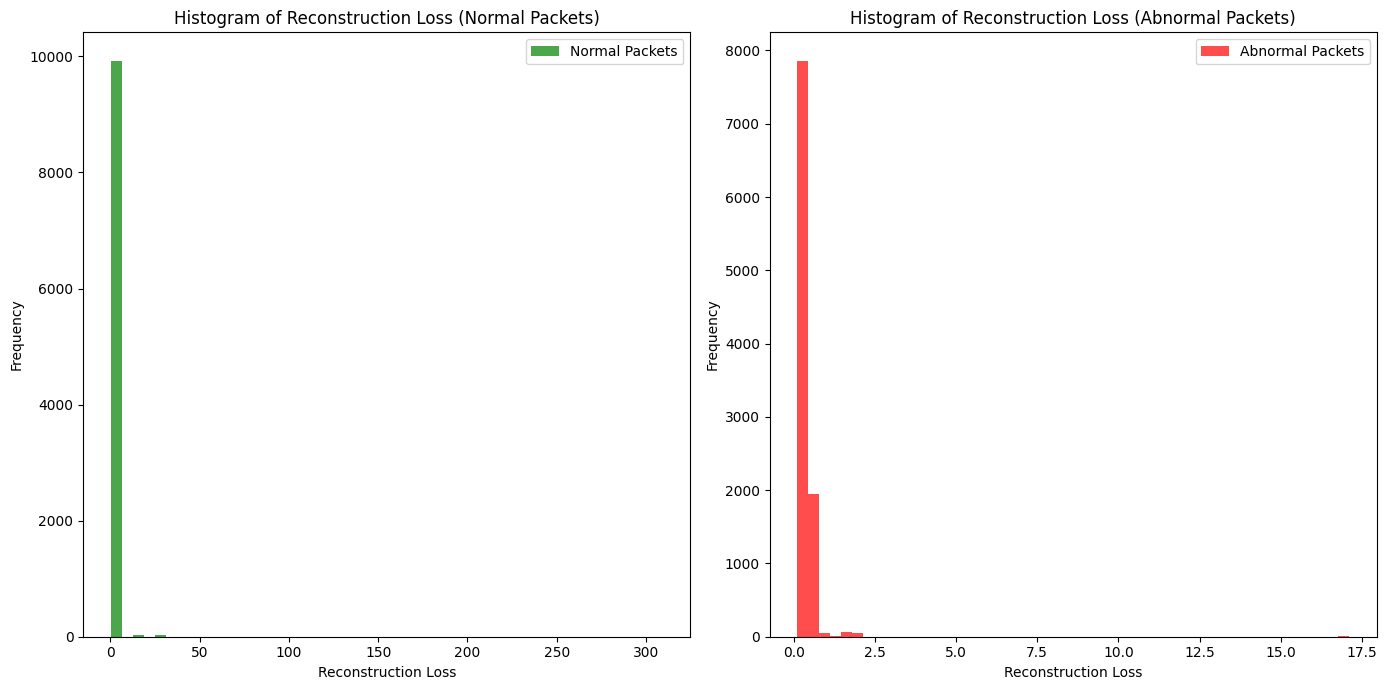

In [131]:
# Predict the normal data
model.eval()
with torch.no_grad():
    normal_output = model(df_normal_features_scaled_tensor)
    normal_loss = criterion(normal_output, df_normal_features_scaled_tensor)
    normal_mse_loss = np.mean(np.power(df_normal_features_scaled_tensor.cpu().numpy() - normal_output.cpu().numpy(), 2), axis=1)

# Predict the attacked data
with torch.no_grad():
    attack_outputs = model(df_attack_features_scaled_tensor)
    attack_loss = criterion(attack_outputs, df_attack_features_scaled_tensor)
    attack_mse_loss = np.mean(np.power(df_attack_features_scaled_tensor.cpu().numpy() - attack_outputs.cpu().numpy(), 2), axis=1)

# Plot histograms of the reconstruction losses
plt.figure(figsize=(14, 7))

# Plot for normal packets
plt.subplot(1, 2, 1)
plt.hist(normal_mse_loss, bins=50, color='g', alpha=0.7, label='Normal Packets')
plt.title('Histogram of Reconstruction Loss (Normal Packets)')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()

# Plot for abnormal packets
plt.subplot(1, 2, 2)
plt.hist(attack_mse_loss, bins=50, color='r', alpha=0.7, label='Abnormal Packets')
plt.title('Histogram of Reconstruction Loss (Abnormal Packets)')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()